<a href="https://colab.research.google.com/github/khanabdulmajid/tensorflow_deep_learning/blob/main/06__Transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with Tensorflow part 3: scaling up

we have seen the power if transfer learning feature extraction and fine tuning , now its time to scale up to all of the classes in food 101(101 toal classes)
Our goal is to beat the original food101 paper with 10% of the training data (leverageing the power of deep learning).

In [1]:
# !wget https://github.com/khanabdulmajid/tensorflow_deep_learning/a90154efbfd5eaf7734bf1e073a94b98d09946dd/helper_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-09-08 05:57:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-09-08 05:57:18 (18.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2023-09-08 05:57:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
unzip_data("/content/101_food_classes_10_percent.zip")

In [4]:
# !mkdir modelcheckpoint

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import preprocessing

In [6]:
checkpoint_path="/content/modelcheckpoint/model.ckpt"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       monitor="val_accuracy",
                                                       save_best_only=True,
                                                       save_weights_only=True)
train_dir="/content/101_food_classes_10_percent/train"
test_dir="/content/101_food_classes_10_percent/test"

In [7]:
IMG_SIZE=(224,224)
train_data_10_percent=preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE
                                                                 )
test_data=preprocessing.image_dataset_from_directory(test_dir,
                                                     label_mode="categorical",
                                                     image_size=IMG_SIZE,
                                                     shuffle=False
                                                     )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
data_augmentation=Sequential([
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.2)
],  name="data_augmentation")

base_model =tf.keras.applications.EfficientNetB0(include_top=False)

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
len(train_data_10_percent.class_names)

101

In [ ]:
base_model.trainable=False

inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="GLobalbalAvgPooling")(x)
outputs=tf.keras.layers.Dense(len(train_data_10_percent.class_names),activation="softmax",name="output_layer_10")(x)
model_0=tf.keras.Model(inputs,outputs)

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GLobalbalAvgPooling (Global  (None, 1280)             0         
 AveragePooling2D)                                               
                                                                 
 output_layer_10 (Dense)     (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [ ]:

history_model_0=model_0.fit(train_data_10_percent,
                            epochs=5,
                            validation_data=test_data,
                            validation_steps=int(0.15*len(test_data)),
                            callbacks=[checkpoint_callback]
                )

Epoch 1/5
237/237 [==============================] - 1199s 5s/step - loss: 3.3796 - accuracy: 0.2743 - val_loss: 2.4257 - val_accuracy: 0.4725
Epoch 2/5
237/237 [==============================] - 1012s 4s/step - loss: 2.2190 - accuracy: 0.4912 - val_loss: 2.0165 - val_accuracy: 0.5124
Epoch 3/5
237/237 [==============================] - 1015s 4s/step - loss: 1.8464 - accuracy: 0.5564 - val_loss: 1.8994 - val_accuracy: 0.5228
Epoch 4/5
237/237 [==============================] - 985s 4s/step - loss: 1.6365 - accuracy: 0.5978 - val_loss: 1.7600 - val_accuracy: 0.5450
Epoch 5/5
237/237 [==============================] - 972s 4s/step - loss: 1.4906 - accuracy: 0.6286 - val_loss: 1.7173 - val_accuracy: 0.5543


In [ ]:
#making some layers trainable in base model
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
initial_epoch=5
fine_tuning_epoch=5+initial_epoch
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"]
                )

fine_tuning_1_history=model_0.fit(train_data_10_percent,
            epochs=fine_tuning_epoch,
            validation_data=test_data,
            validation_steps=int(0.15*len(test_data)),
            initial_epoch=history_model_0.epoch[-1],
            callbacks=[checkpoint_callback]

)

Epoch 5/10
237/237 [==============================] - ETA: 0s - loss: 1.5033 - accuracy: 0.5993

# Loading weights from trained model

In [8]:
from tensorflow.keras import layers,Sequential
import tensorflow as tf
def create_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 101,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # data augmentation layer
    data_augmentation=Sequential([
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.2)
                                ],
                                name="data_augmentation")

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
downloaded_model = create_model()

24274472/24274472 [==============================] - 0s 0us/step


In [9]:
unzip_data("/content/drive/MyDrive/ZTM Files/file(1).zip")

In [10]:
downloaded_model.load_weights("/content/content/tensorflow_course/10_percent_food_data_saved_model")

In [11]:
# downloaded_model.evaluate(test_data)

#Making Predictions with our Model

In [18]:
pred_probs=downloaded_model.predict(test_data, verbose=1)

790/790 [==============================] - 79s 87ms/step


In [79]:
downloaded_model.evaluate(test_data)

790/790 [==============================] - 64s 77ms/step - loss: 2.0397 - accuracy: 0.5914


[2.039691925048828, 0.5914455652236938]

In [ ]:
pred_probs

array([[6.30276263e-01, 4.47514940e-05, 7.29575462e-04, ...,
        2.59059663e-10, 4.00658500e-05, 2.99134190e-05],
       [8.67650509e-01, 1.89030033e-07, 1.64795012e-04, ...,
        5.65907249e-05, 1.06934522e-06, 9.09754272e-06],
       [9.73274231e-01, 7.79903075e-08, 2.07868652e-05, ...,
        2.14787939e-08, 6.91984496e-08, 1.09849105e-04],
       ...,
       [1.11089842e-02, 7.42315365e-07, 1.48418466e-09, ...,
        2.33107116e-08, 1.40782840e-05, 9.47936833e-01],
       [1.42348791e-03, 9.59027020e-05, 2.43775412e-05, ...,
        5.32035250e-03, 3.87439014e-09, 4.72876728e-01],
       [8.22177797e-04, 6.32670299e-06, 1.09424604e-07, ...,
        3.64069479e-06, 4.08120655e-07, 9.15288568e-01]], dtype=float32)

In [ ]:
print(pred_probs.argmax(axis=1))

[  0   0   0 ... 100 100 100]


In [ ]:
pred_probs[0].argmax

<function ndarray.argmax>

- How will you know the predicted class is rightly predicted by the model.


In [19]:
pred_classes=pred_probs.argmax(axis=1)

In [20]:
labels=[]
for image,label in test_data.unbatch():
  labels.append(label.numpy().argmax())

In [21]:
class_names=test_data.class_names

In [22]:
class_names[0]

'apple_pie'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("/content/101_food_classes_10_percent/test/apple_pie/1375404.jpg")
plt.imshow(img)

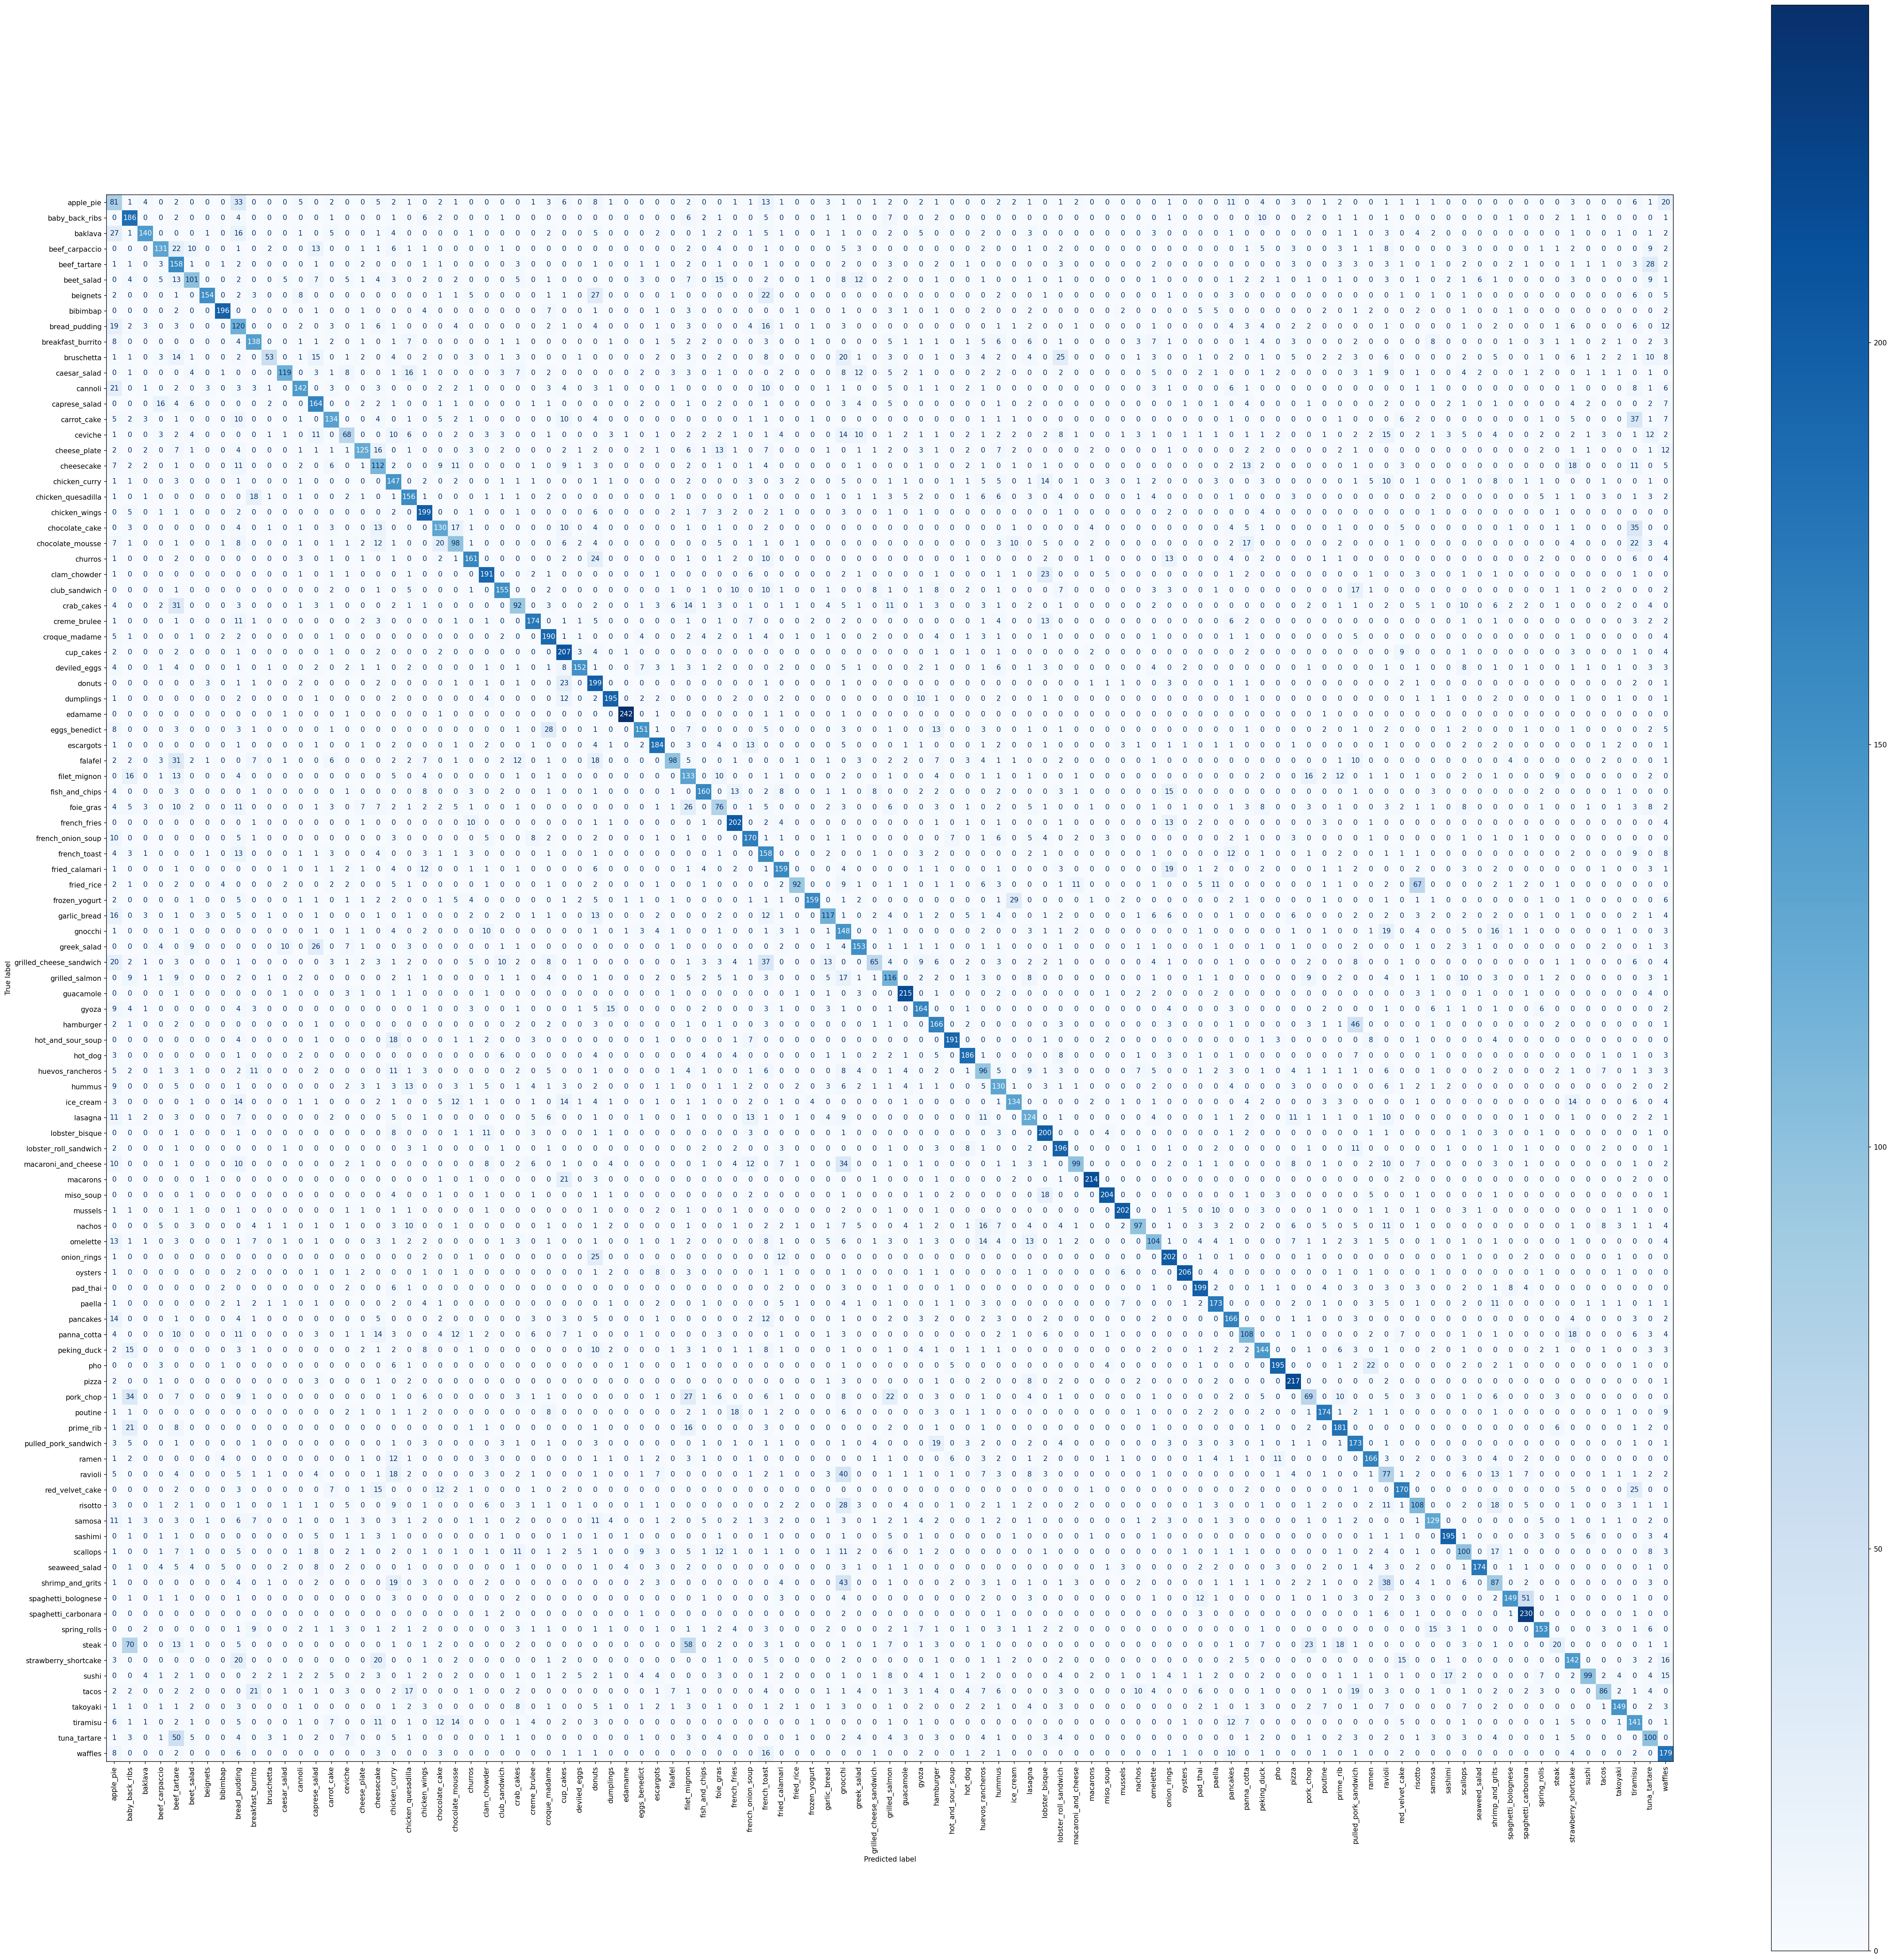

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=labels,
                                            y_pred=pred_classes,
                                            display_labels=class_names,
                                            cmap="Blues",
                                            xticks_rotation="vertical",
                                            # make it bigger
                                            ax=plt.figure(figsize=(50, 50), dpi=150).subplots())

In [ ]:
test_data.element_spec

#Lets keep the evaluation train going, time for a classificaiton report

scikit lean has a helpful function for acquiring many different classification metrics per class (eg, f1 score, precision, recall) called classification_report, lets try it out.


In [63]:
from sklearn.metrics import classification_report

classification_report_dict=classification_report(y_true=labels,
                            y_pred=pred_classes,
                                                 output_dict=True)

In [64]:
classification_report_dict

{'0': {'precision': 0.19285714285714287,
  'recall': 0.324,
  'f1-score': 0.2417910447761194,
  'support': 250},
 '1': {'precision': 0.4439140811455847,
  'recall': 0.744,
  'f1-score': 0.5560538116591929,
  'support': 250},
 '2': {'precision': 0.7821229050279329,
  'recall': 0.56,
  'f1-score': 0.6526806526806528,
  'support': 250},
 '3': {'precision': 0.6717948717948717,
  'recall': 0.524,
  'f1-score': 0.5887640449438203,
  'support': 250},
 '4': {'precision': 0.3147410358565737,
  'recall': 0.632,
  'f1-score': 0.4202127659574468,
  'support': 250},
 '5': {'precision': 0.6011904761904762,
  'recall': 0.404,
  'f1-score': 0.48325358851674644,
  'support': 250},
 '6': {'precision': 0.9166666666666666,
  'recall': 0.616,
  'f1-score': 0.7368421052631579,
  'support': 250},
 '7': {'precision': 0.8949771689497716,
  'recall': 0.784,
  'f1-score': 0.8358208955223881,
  'support': 250},
 '8': {'precision': 0.2696629213483146,
  'recall': 0.48,
  'f1-score': 0.3453237410071942,
  'support'

In [24]:
# lets plot all of our classes f1Score
#create an empty dictionary
class_f1_score={}
for k,v in classification_report_dict.items():
  if k=="accuracy":
    break
  else:
    class_f1_score[class_names[int(k)]] = v["f1-score"]
class_f1_score

{'apple_pie': 0.2417910447761194,
 'baby_back_ribs': 0.5560538116591929,
 'baklava': 0.6526806526806528,
 'beef_carpaccio': 0.5887640449438203,
 'beef_tartare': 0.4202127659574468,
 'beet_salad': 0.48325358851674644,
 'beignets': 0.7368421052631579,
 'bibimbap': 0.8358208955223881,
 'bread_pudding': 0.3453237410071942,
 'breakfast_burrito': 0.5564516129032259,
 'bruschetta': 0.3281733746130031,
 'caesar_salad': 0.5935162094763092,
 'cannoli': 0.6439909297052153,
 'caprese_salad': 0.590990990990991,
 'carrot_cake': 0.5826086956521739,
 'ceviche': 0.34517766497461927,
 'cheese_plate': 0.5813953488372093,
 'cheesecake': 0.4155844155844156,
 'chicken_curry': 0.4666666666666666,
 'chicken_quesadilla': 0.5965583173996176,
 'chicken_wings': 0.7119856887298748,
 'chocolate_cake': 0.5473684210526315,
 'chocolate_mousse': 0.4251626898047723,
 'churros': 0.6807610993657506,
 'clam_chowder': 0.7332053742802304,
 'club_sandwich': 0.6828193832599119,
 'crab_cakes': 0.41818181818181815,
 'creme_brule

In [25]:
import pandas as pd

# turnn f1 scores in data Fame
f1_scores=pd.DataFrame.from_dict({"class_names":list(class_f1_score.keys()),"f1-score":list(class_f1_score.values())}).sort_values("f1-score",ascending=False)

In [26]:
f1_scores

,class_names,f1-score
33,edamame,0.964143
63,macarons,0.884298
69,oysters,0.872881
64,miso_soup,0.850000
51,guacamole,0.843137
...,...,...
39,foie_gras,0.337029
10,bruschetta,0.328173
82,ravioli,0.266898
0,apple_pie,0.241791


# Visualizing predictions on test images

Now, this is the real test,  how does our model go on food images not even in our dataset (images of our own, we'll see this later on)

To visialize our model's predictions on own images, we'll need a function to load and preprocess images, specifically it willl need to:
* Read in a target image filepath using tf.io.read_file()
* turn the img into tensor using tf.io.decode_image()
* resize the image tensor to same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [27]:
# creae a function to load and preprocess the custom image
def load_and_prep_image(filepath,image_shape, scale=True):

  img=tf.io.read_file(filepath)
  img_tensor=tf.io.decode_image(img,channels=3)

  #resize
  img=tf.image.resize(img_tensor,image_shape)
  if scale == True:
    return img/255.
  return img



Now we've got a function to load and preprare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image along with the model's prediction

1/1 [==============================] - 0s 166ms/step
pred_prob = 38
1/1 [==============================] - 0s 88ms/step
pred_prob = 54
1/1 [==============================] - 0s 68ms/step
pred_prob = 61


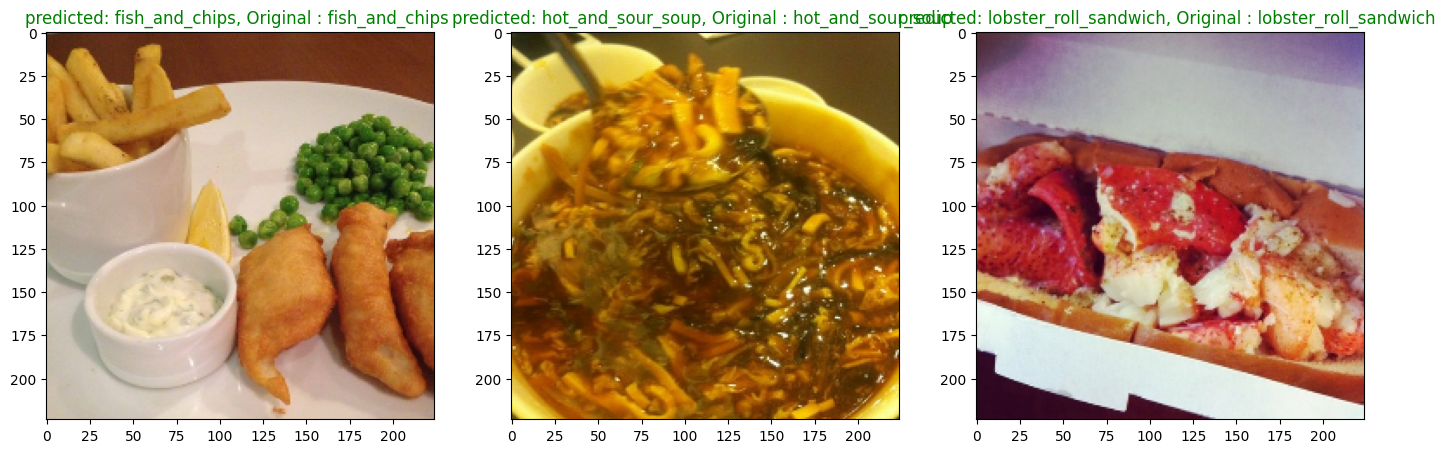

In [84]:
import random
import matplotlib.pyplot as plt

import os
plt.figure(figsize=(17,10))
for i in range(0,3):
  class_name=random.choice(class_names)
  filename=random.choice(os.listdir(test_dir+"/"+class_name))
  filepath=test_dir +"/"+ class_name +"/"+filename

  img=load_and_prep_image(filepath,(224,224),scale=False)
  expanded_image= tf.expand_dims(img,axis=0)
  pred_prob=downloaded_model.predict(expanded_image)
  pred_class_name=class_names[pred_prob.argmax()]
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)

  if pred_class_name == class_name:
    title_color='g'
  else:
    title_color="r"

  plt.title(f"predicted: {pred_class_name}, Original : {class_name} ", c=title_color)
  print(f"pred_prob = {pred_prob.argmax()}")

In [81]:
filepath

'/content/101_food_classes_10_percent/test/chocolate_mousse/3449482.jpg'

In [54]:
tf.argmax(downloaded_model.predict(tf.expand_dims(img,axis=0)),axis=1)

1/1 [==============================] - 0s 51ms/step


<tf.Tensor: shape=(1,), dtype=int64, numpy=array([76])>

In [ ]:
filepath='/content/101_food_classes_10_percent/test'+'/'+class_name

'ceviche'

In [ ]:
def image_pred(image:tf.tensor,model:tf.keras.Model):
  pred=model.predict(image)
  classes=
  title=


SyntaxError: ignored